### Topic Modelling - and more - with Gensim!

This tutorial will attempt to walk you through the entire process of analysing your text - from pre-processing to creating your topic models and visualising them. 

python offers a very rich suite of NLP and CL tools, and we will illustrate these to the best of our capabilities.
Let's start by setting up our imports.

We will be needing: 
```
- Gensim
- matplotlib
- spaCy
- pyLDAVis
```


In [1]:
import matplotlib.pyplot as plt
import gensim
import numpy as np
import spacy

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import os, re, operator, warnings
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now
%matplotlib inline

For this tutorial, we will be using the Lee corpus which is a shortened version of the [Lee Background Corpus](http://www.socsci.uci.edu/~mdlee/lee_pincombe_welsh_document.PDF). The shortened version consists of 300 documents selected from the Australian Broadcasting Corporation's news mail service. It consists of texts of headline stories from around the year 2000-2001. 

We should keep in mind we can use pretty much any textual data-set and go ahead with what we will be doing.

In [2]:
# since we're working in python 2.7 in this tutorial, we need to make sure to clean our data to make it unicode consistent
def clean(text):
    return unicode(''.join([i if ord(i) < 128 else ' ' for i in text]))

test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_train_file = test_data_dir + os.sep + 'lee_background.cor'
text = open(lee_train_file).read()

### Pre-processing data!

It's been often said in Machine Learning and NLP algorithms - garbage in, garbage out. We can't have state-of-the-art results without data which is aa good. Let's spend this section working on cleaning and understanding our data set.
NTLK is usually a popular choice for pre-processing - but is a rather [outdated](https://explosion.ai/blog/dead-code-should-be-buried) and we will be checking out spaCy, an industry grade text-processing package. 

In [3]:
from spacy.en import English
nlp = spacy.load("en")

For safe measure, let's add some stopwords. It's a newspaper corpus, so it is likely we will be coming across variations of 'said' and 'Mister' which will not really add any value to the topic models.

In [4]:
my_stop_words = [u'say', u'\'s', u'Mr', u'be', u'said', u'says', u'saying']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [5]:
doc = nlp(clean(text))

Voila! With the `English` pipeline, all the heavy lifting has been done. Let's see what went on under the hood.

In [6]:
doc

Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wales as strong winds today pushed a huge bushfire towards the town of Hill Top. A new blaze near Goulburn, south-west of Sydney, has forced the closure of the Hume Highway. At about 4:00pm AEDT, a marked deterioration in the weather as a storm cell moved east across the Blue Mountains forced authorities to make a decision to evacuate people from homes in outlying streets at Hill Top in the New South Wales southern highlands. An estimated 500 residents have left their homes for nearby Mittagong. The New South Wales Rural Fire Service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around Hill Top are optimistic of defending all properties. As more than 100 blazes burn on New Year's Eve in New South Wales, fire crews have been called to new fire at Gunning, south of Goulburn. While few details are available at this

It seems like nothing, right? But spaCy's internal data structure has done all the work for us. Let's see how we can create our corpus. You can check out what a gensim corpus looks like [here](google.com).

In [7]:
# we add some words to the stop word list
texts, article = [], []
for w in doc:
    # if it's not a stop word or punctuation mark, add it to our article!
    if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num:
        # we add the lematized version of the word
        article.append(w.lemma_)
    # if it's a new line, it means we're onto our next document
    if w.text == '\n':
        texts.append(article)
        article = []

And this is the magic of spaCy - just like that, we've managed to get rid of stopwords, punctauation markers, and added the lemmatized word. There's lot more we can do with spaCy which I would really recommend checking out.

Sometimes topic models make more sense when 'New' and 'York' are treated as 'New_York' - we can do this by creating a bigram model and modifying our corpus accordingly.

In [8]:
bigram = gensim.models.Phrases(texts)

In [9]:
texts = [bigram[line] for line in texts]

In [10]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

We're now done with a very important part of any text analysis - the data cleaning and setting up of corpus. It must be kept in mind that we created the corpus the way we did because that's how gensim requires it - most algorithms still require one to clean the data set the way we did, by removing stop words and numbers, adding the lemmatized form of the word, and using bigrams. 

### LSI

LSI stands for Latent Semantic Indeixing - it is a popular information retreival method which works by decomposing the original matrix of words to maintain key topics. Gensim's implementation uses an SVD.

In [11]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [12]:
lsimodel.show_topics(num_topics=5)  # Showing only the top 5 topics

[(0,
  u'-0.216*"israeli" + -0.211*"palestinian" + -0.196*"arafat" + -0.181*"force" + -0.149*"official" + -0.148*"kill" + -0.142*"people" + -0.142*"attack" + -0.129*"government" + -0.127*"australian"'),
 (1,
  u'-0.321*"palestinian" + -0.306*"israeli" + -0.299*"arafat" + 0.171*"australia" + 0.166*"australian" + -0.158*"israel" + 0.149*"afghanistan" + -0.137*"sharon" + -0.134*"hamas" + -0.124*"west_bank"'),
 (2,
  u'-0.266*"afghanistan" + -0.242*"force" + -0.191*"al_qaeda" + 0.180*"fire" + -0.176*"bin_laden" + -0.153*"pakistan" + 0.138*"good" + 0.138*"sydney" + -0.131*"tora_bora" + -0.129*"afghan"'),
 (3,
  u'0.373*"fire" + 0.270*"area" + 0.199*"sydney" + -0.191*"australia" + 0.176*"firefighter" + 0.160*"south" + 0.157*"north" + 0.148*"wind" + -0.146*"good" + 0.132*"wales"'),
 (4,
  u'-0.238*"company" + -0.221*"union" + 0.199*"test" + -0.187*"qantas" + -0.152*"australian" + 0.145*"good" + 0.141*"match" + 0.137*"win" + -0.136*"government" + -0.136*"worker"')]

### HDP

HDP, the Hierarchical Dirichlet process is an unsupervised topic model which figures out the number of topics on it's own.

In [13]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [14]:
hdpmodel.show_topics()

[(0,
  u'0.005*israeli + 0.003*arafat + 0.003*palestinian + 0.003*hit + 0.003*west_bank + 0.003*official + 0.002*sharon + 0.002*force + 0.002*afp + 0.002*arrest + 0.002*militant + 0.002*storm + 0.002*hamas + 0.002*strike + 0.002*come + 0.002*military + 0.002*source + 0.002*group + 0.002*soldier + 0.002*kill'),
 (1,
  u'0.004*company + 0.003*administrator + 0.002*yallourn + 0.002*entitlement + 0.002*traveland + 0.002*staff + 0.002*austar + 0.002*union + 0.002*travel + 0.002*employee + 0.002*end + 0.002*cent + 0.002*government + 0.002*remain + 0.002*go + 0.002*seek + 0.002*leave + 0.002*people + 0.002*agreement + 0.002*$'),
 (2,
  u'0.003*airport + 0.003*taliban + 0.002*kill + 0.002*opposition + 0.002*kandahar + 0.002*force + 0.002*night + 0.002*leave + 0.002*man + 0.002*lali + 0.002*near + 0.002*city + 0.001*wound + 0.001*end + 0.001*agha + 0.001*civilian + 0.001*gul + 0.001*people + 0.001*military + 0.001*injure'),
 (3,
  u'0.002*job + 0.002*australian + 0.002*cent + 0.002*read + 0.002

### LDA

LDA, or Latent Dirichlet Allocation is arguably the most famous topic modelling algorithm out there. Out here we create a simple topic model with 10 topics.

In [15]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [16]:
ldamodel.show_topics()

[(0,
  u'0.006*"force" + 0.006*"year" + 0.005*"australian" + 0.004*"new" + 0.004*"afghanistan" + 0.004*"people" + 0.004*"official" + 0.004*"area" + 0.004*"fire" + 0.004*"day"'),
 (1,
  u'0.005*"attack" + 0.005*"people" + 0.004*"man" + 0.004*"group" + 0.004*"report" + 0.004*"company" + 0.003*"australia" + 0.003*"force" + 0.003*"kill" + 0.003*"come"'),
 (2,
  u'0.009*"australia" + 0.005*"australian" + 0.005*"government" + 0.004*"day" + 0.003*"new" + 0.003*"united_states" + 0.003*"child" + 0.003*"come" + 0.003*"report" + 0.003*"good"'),
 (3,
  u'0.005*"day" + 0.005*"people" + 0.004*"police" + 0.004*"australian" + 0.004*"australia" + 0.003*"today" + 0.003*"test" + 0.003*"palestinian" + 0.003*"attack" + 0.003*"centre"'),
 (4,
  u'0.008*"australian" + 0.005*"fire" + 0.005*"year" + 0.005*"government" + 0.005*"people" + 0.004*"union" + 0.004*"south" + 0.004*"centre" + 0.003*"company" + 0.003*"day"'),
 (5,
  u'0.008*"israeli" + 0.006*"palestinian" + 0.005*"force" + 0.004*"fire" + 0.004*"people"

### pyLDAvis 

Thanks to pyLDAvis, we can visualise our topic models in a really handy way. All we need to do is enable our notebook and prepare the object.

In [22]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      20.629337        1       1 -0.031791 -0.027891
0      12.905266        1       2  0.004317  0.010642
3      10.173109        1       3 -0.014312  0.011161
6       9.588046        1       4  0.043393 -0.003117
2       9.421682        1       5  0.029660 -0.027211
7       7.752333        1       6 -0.045081  0.006402
4       7.615487        1       7  0.037983  0.063091
8       7.539375        1       8  0.039796 -0.047300
1       7.404629        1       9 -0.041340 -0.014208
9       6.970736        1      10 -0.022625  0.028433, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
4617  Default  121.000000     australian  121.000000  30.0000  30.0000
633   Default   38.000000          world   38.000000  29.0000  29.0000
4761  Default   38.000000       pakistan   38.000000  28.0000  28.0000
1873  Default   98.000000           year   98.000000  27.0000  27.0000
926   Default   74.000000           fire   74.000000  26.0000  26.0000
1489  Default   29.000000          india   29.000000  25.0000  25.0000
4901  Default   27.000000         qantas   27.000000  24.0000  24.0000
232   Default   50.000000          union   50.000000  23.0000  23.0000
972   Default  122.000000      australia  122.000000  22.0000  22.0000
3239  Default   69.000000            man   69.000000  21.0000  21.0000
3225  Default   47.000000          claim   47.000000  20.0000  20.0000
1092  Default   22.000000         indian   22.000000  19.0000  19.0000
3006  Default   27.000000     commission   27.000000  18.0000  18.0000
1826  Default   22.000000        economy   22.000000  17.0000  17.0000
759   Default   60.000000        company   60.000000  16.0000  16.0000
298   Default  113.000000         people  113.000000  15.0000  15.0000
5280  Default   24.000000          metre   24.000000  14.0000  14.0000
1344  Default   99.000000     government   99.000000  13.0000  13.0000
858   Default    7.000000          virus    7.000000  12.0000  12.0000
5410  Default   37.000000         centre   37.000000  11.0000  11.0000
414   Default   20.000000         wicket   20.000000  10.0000  10.0000
4470  Default   21.000000       detainee   21.000000   9.0000   9.0000
2548  Default   75.000000         attack   75.000000   8.0000   8.0000
2644  Default   43.000000           cent   43.000000   7.0000   7.0000
3615  Default   59.000000           good   59.000000   6.0000   6.0000
1341  Default   50.000000         arrest   50.000000   5.0000   5.0000
1575  Default   19.000000           rate   19.000000   4.0000   4.0000
4011  Default   48.000000          south   48.000000   3.0000   3.0000
551   Default   13.000000        dispute   13.000000   2.0000   2.0000
4454  Default   18.000000          catch   18.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
3225  Topic10    6.818107          claim   47.636185   0.7194  -5.6895
3422  Topic10    5.279711            pay   33.005504   0.8306  -5.9452
1277  Topic10    2.412867      explosive    9.586679   1.2839  -6.7282
239   Topic10    4.531026         worker   26.657778   0.8913  -6.0981
298   Topic10   10.952928         people  113.955664   0.3212  -5.2154
2817  Topic10    7.659687           tell   68.750885   0.4689  -5.5731
5098  Topic10    3.055805            hih   14.389699   1.1140  -6.4920
1054  Topic10    4.870582        fighter   32.538250   0.7642  -6.0258
3215  Topic10    2.617848     east_timor   11.217835   1.2083  -6.6467
972   Topic10    9.924347      australia  122.743143   0.1483  -5.3141
540   Topic10    4.357381        federal   28.541665   0.7840  -6.1372
3057  Topic10    6.720653  united_states   62.865899   0.4276  -5.7039
4188  Topic10    4.689575      bin_laden   34.033117   0.6815  -6.0637
5330  Topic10    2.424794        tension   

### Round-up

Okay - so what have we learned so far? 
By using spaCy, we cleaned up our data super fast. It's worth noting that by running our doc through the pipeline we also know about every single words POS-tag and NER-tag. This is useful information and we can do some funky things with it! I would highly recommend going through [this](https://github.com/explosion/spacy-notebooks) repository to see examples of hands-on spaCy usage.

As for gensim and topic modelling, it's pretty easy to see how well we could create our topic models. Now the obvious next question is - how do we use these topic models? The [news classification notebook](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/gensim_news_classification.ipynb) in the Gensim [notebooks](https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks) directory is a good example of how we can use topic models in a practical scenario.

We will continue this tutorial by demonstrating a newer topic modelling features of gensim - in particular, Topic Coherence. 

### Topic Coherence

Topic Coherence is a new gensim functionality where we can identify which topic model is 'better'. 
By returning a score, we can compare between different topic models of the same. We use the same example from the news classification notebook to plot a graph between the topic models we have created.

In [18]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [19]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

In [20]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

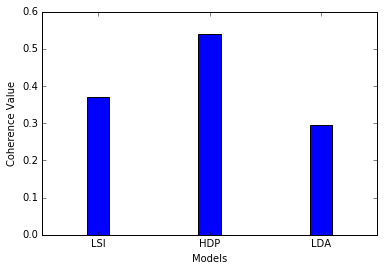

In [21]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
                   ['LSI', 'HDP', 'LDA'])

We can see that topic coherence helped us get past manually inspecting our topic models - we can now keep fine tuning our models and compare between them to see which has the best performance. 

This also brings us to the end of the runnable part of this tutorial - we will continue however by briefly going over two more Jupyter notebooks I have previously worked on - mainly, [Dynamic Topic Modelling](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) and [Document Word Coloring](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_methods.ipynb).